# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "nQuery_oracle.run2",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_target": 1000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "num_examples_per_domain_per_label_source": 10000,
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.0048365397
Average power, source: 2.9325745e-05


Average magnitude, target: 0.0029128897
Average power, target: 1.0910343e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 4200], examples_per_second: 74.5743, train_label_loss: 2.3644, 


epoch: 1, [batch: 420 / 4200], examples_per_second: 3190.0659, train_label_loss: 1.4084, 


epoch: 1, [batch: 840 / 4200], examples_per_second: 3192.0214, train_label_loss: 0.9798, 


epoch: 1, [batch: 1260 / 4200], examples_per_second: 3147.5676, train_label_loss: 1.0459, 


epoch: 1, [batch: 1680 / 4200], examples_per_second: 3179.9314, train_label_loss: 0.2895, 


epoch: 1, [batch: 2100 / 4200], examples_per_second: 3166.0379, train_label_loss: 0.3374, 


epoch: 1, [batch: 2520 / 4200], examples_per_second: 3208.5819, train_label_loss: 0.2424, 


epoch: 1, [batch: 2940 / 4200], examples_per_second: 3094.0953, train_label_loss: 0.6113, 


epoch: 1, [batch: 3360 / 4200], examples_per_second: 3148.4683, train_label_loss: 0.4983, 


epoch: 1, [batch: 3780 / 4200], examples_per_second: 3127.3453, train_label_loss: 0.5832, 


epoch: 1, source_val_acc_label: 0.6970, target_val_acc_label: 0.5096, source_val_label_loss: 78.1766, target_val_label_loss: 54.3337, 


New best


epoch: 2, [batch: 1 / 4200], examples_per_second: 5.7207, train_label_loss: 213.3344, 


epoch: 2, [batch: 420 / 4200], examples_per_second: 3170.7408, train_label_loss: 0.3768, 


epoch: 2, [batch: 840 / 4200], examples_per_second: 3234.9285, train_label_loss: 0.4417, 


epoch: 2, [batch: 1260 / 4200], examples_per_second: 3186.8223, train_label_loss: 0.4759, 


epoch: 2, [batch: 1680 / 4200], examples_per_second: 3179.5951, train_label_loss: 0.4675, 


epoch: 2, [batch: 2100 / 4200], examples_per_second: 3037.2624, train_label_loss: 0.4514, 


epoch: 2, [batch: 2520 / 4200], examples_per_second: 3054.2217, train_label_loss: 0.5316, 


epoch: 2, [batch: 2940 / 4200], examples_per_second: 3231.5092, train_label_loss: 0.3815, 


epoch: 2, [batch: 3360 / 4200], examples_per_second: 3234.7824, train_label_loss: 0.4365, 


epoch: 2, [batch: 3780 / 4200], examples_per_second: 3248.8903, train_label_loss: 0.5447, 


epoch: 2, source_val_acc_label: 0.8180, target_val_acc_label: 0.6680, source_val_label_loss: 0.5118, target_val_label_loss: 1.1871, 


New best


epoch: 3, [batch: 1 / 4200], examples_per_second: 5.8009, train_label_loss: 0.6806, 


epoch: 3, [batch: 420 / 4200], examples_per_second: 3110.8252, train_label_loss: 0.7855, 


epoch: 3, [batch: 840 / 4200], examples_per_second: 2902.9931, train_label_loss: 0.7515, 


epoch: 3, [batch: 1260 / 4200], examples_per_second: 2922.9928, train_label_loss: 0.5409, 


epoch: 3, [batch: 1680 / 4200], examples_per_second: 2927.0150, train_label_loss: 0.6525, 


epoch: 3, [batch: 2100 / 4200], examples_per_second: 2917.8995, train_label_loss: 0.2395, 


epoch: 3, [batch: 2520 / 4200], examples_per_second: 3075.1868, train_label_loss: 0.6229, 


epoch: 3, [batch: 2940 / 4200], examples_per_second: 3220.5849, train_label_loss: 0.2572, 


epoch: 3, [batch: 3360 / 4200], examples_per_second: 2933.7368, train_label_loss: 0.2629, 


epoch: 3, [batch: 3780 / 4200], examples_per_second: 2919.3417, train_label_loss: 0.2319, 


epoch: 3, source_val_acc_label: 0.8478, target_val_acc_label: 0.6982, source_val_label_loss: 0.4441, target_val_label_loss: 1.2404, 


epoch: 4, [batch: 1 / 4200], examples_per_second: 5.2808, train_label_loss: 0.4263, 


epoch: 4, [batch: 420 / 4200], examples_per_second: 2931.9894, train_label_loss: 0.6746, 


epoch: 4, [batch: 840 / 4200], examples_per_second: 2939.6946, train_label_loss: 0.4385, 


epoch: 4, [batch: 1260 / 4200], examples_per_second: 2935.3982, train_label_loss: 0.2815, 


epoch: 4, [batch: 1680 / 4200], examples_per_second: 2911.7303, train_label_loss: 0.8117, 


epoch: 4, [batch: 2100 / 4200], examples_per_second: 2919.5784, train_label_loss: 0.2893, 


epoch: 4, [batch: 2520 / 4200], examples_per_second: 2948.8020, train_label_loss: 0.1231, 


epoch: 4, [batch: 2940 / 4200], examples_per_second: 2932.1821, train_label_loss: 0.2425, 


epoch: 4, [batch: 3360 / 4200], examples_per_second: 2933.7105, train_label_loss: 0.1378, 


epoch: 4, [batch: 3780 / 4200], examples_per_second: 2943.2672, train_label_loss: 0.3807, 


epoch: 4, source_val_acc_label: 0.8636, target_val_acc_label: 0.7095, source_val_label_loss: 0.4035, target_val_label_loss: 1.1767, 


New best


epoch: 5, [batch: 1 / 4200], examples_per_second: 5.3855, train_label_loss: 0.1522, 


epoch: 5, [batch: 420 / 4200], examples_per_second: 2910.2777, train_label_loss: 0.1662, 


epoch: 5, [batch: 840 / 4200], examples_per_second: 2911.5692, train_label_loss: 0.3144, 


epoch: 5, [batch: 1260 / 4200], examples_per_second: 2901.1266, train_label_loss: 0.3116, 


epoch: 5, [batch: 1680 / 4200], examples_per_second: 2915.0387, train_label_loss: 0.4918, 


epoch: 5, [batch: 2100 / 4200], examples_per_second: 2906.0297, train_label_loss: 0.3659, 


epoch: 5, [batch: 2520 / 4200], examples_per_second: 2907.0944, train_label_loss: 0.6340, 


epoch: 5, [batch: 2940 / 4200], examples_per_second: 2903.0664, train_label_loss: 0.3613, 


epoch: 5, [batch: 3360 / 4200], examples_per_second: 2905.7782, train_label_loss: 0.4933, 


epoch: 5, [batch: 3780 / 4200], examples_per_second: 2890.2882, train_label_loss: 0.2857, 


epoch: 5, source_val_acc_label: 0.8512, target_val_acc_label: 0.7111, source_val_label_loss: 0.4492, target_val_label_loss: 1.3329, 


epoch: 6, [batch: 1 / 4200], examples_per_second: 5.3469, train_label_loss: 0.4671, 


epoch: 6, [batch: 420 / 4200], examples_per_second: 2882.6788, train_label_loss: 0.2502, 


epoch: 6, [batch: 840 / 4200], examples_per_second: 2891.0531, train_label_loss: 0.3151, 


epoch: 6, [batch: 1260 / 4200], examples_per_second: 2925.8302, train_label_loss: 0.2845, 


epoch: 6, [batch: 1680 / 4200], examples_per_second: 2909.6287, train_label_loss: 0.3931, 


epoch: 6, [batch: 2100 / 4200], examples_per_second: 2900.4786, train_label_loss: 0.5514, 


epoch: 6, [batch: 2520 / 4200], examples_per_second: 2912.2780, train_label_loss: 0.5967, 


epoch: 6, [batch: 2940 / 4200], examples_per_second: 3053.5882, train_label_loss: 0.2014, 


epoch: 6, [batch: 3360 / 4200], examples_per_second: 3184.2762, train_label_loss: 0.2833, 


epoch: 6, [batch: 3780 / 4200], examples_per_second: 3035.4157, train_label_loss: 0.3273, 


epoch: 6, source_val_acc_label: 0.8687, target_val_acc_label: 0.7260, source_val_label_loss: 0.3780, target_val_label_loss: 1.1307, 


New best


epoch: 7, [batch: 1 / 4200], examples_per_second: 5.3008, train_label_loss: 0.4013, 


epoch: 7, [batch: 420 / 4200], examples_per_second: 2862.3257, train_label_loss: 0.0957, 


epoch: 7, [batch: 840 / 4200], examples_per_second: 2913.8452, train_label_loss: 0.6611, 


epoch: 7, [batch: 1260 / 4200], examples_per_second: 2900.0158, train_label_loss: 0.4525, 


epoch: 7, [batch: 1680 / 4200], examples_per_second: 2920.0536, train_label_loss: 0.4492, 


epoch: 7, [batch: 2100 / 4200], examples_per_second: 2955.4327, train_label_loss: 0.2462, 


epoch: 7, [batch: 2520 / 4200], examples_per_second: 2926.0468, train_label_loss: 0.4581, 


epoch: 7, [batch: 2940 / 4200], examples_per_second: 2914.5821, train_label_loss: 0.3033, 


epoch: 7, [batch: 3360 / 4200], examples_per_second: 2914.2582, train_label_loss: 0.2628, 


epoch: 7, [batch: 3780 / 4200], examples_per_second: 2911.8648, train_label_loss: 0.4575, 


epoch: 7, source_val_acc_label: 0.8776, target_val_acc_label: 0.7538, source_val_label_loss: 0.3419, target_val_label_loss: 0.8494, 


New best


epoch: 8, [batch: 1 / 4200], examples_per_second: 5.3156, train_label_loss: 0.2862, 


epoch: 8, [batch: 420 / 4200], examples_per_second: 3140.7287, train_label_loss: 0.1385, 


epoch: 8, [batch: 840 / 4200], examples_per_second: 3207.3534, train_label_loss: 0.0930, 


epoch: 8, [batch: 1260 / 4200], examples_per_second: 3200.7988, train_label_loss: 0.2040, 


epoch: 8, [batch: 1680 / 4200], examples_per_second: 3189.8370, train_label_loss: 0.5221, 


epoch: 8, [batch: 2100 / 4200], examples_per_second: 3162.9297, train_label_loss: 0.2095, 


epoch: 8, [batch: 2520 / 4200], examples_per_second: 3206.0788, train_label_loss: 0.2202, 


epoch: 8, [batch: 2940 / 4200], examples_per_second: 3201.4953, train_label_loss: 0.1428, 


epoch: 8, [batch: 3360 / 4200], examples_per_second: 3193.1990, train_label_loss: 0.2317, 


epoch: 8, [batch: 3780 / 4200], examples_per_second: 3187.7838, train_label_loss: 0.7444, 


epoch: 8, source_val_acc_label: 0.8837, target_val_acc_label: 0.7524, source_val_label_loss: 0.3577, target_val_label_loss: 1.1612, 


epoch: 9, [batch: 1 / 4200], examples_per_second: 5.9049, train_label_loss: 0.2461, 


epoch: 9, [batch: 420 / 4200], examples_per_second: 3171.5501, train_label_loss: 0.1201, 


epoch: 9, [batch: 840 / 4200], examples_per_second: 3202.8741, train_label_loss: 0.0875, 


epoch: 9, [batch: 1260 / 4200], examples_per_second: 3226.6724, train_label_loss: 0.6809, 


epoch: 9, [batch: 1680 / 4200], examples_per_second: 3210.1533, train_label_loss: 0.4158, 


epoch: 9, [batch: 2100 / 4200], examples_per_second: 3221.1739, train_label_loss: 0.2135, 


epoch: 9, [batch: 2520 / 4200], examples_per_second: 3211.4060, train_label_loss: 0.1564, 


epoch: 9, [batch: 2940 / 4200], examples_per_second: 3230.8874, train_label_loss: 0.3912, 


epoch: 9, [batch: 3360 / 4200], examples_per_second: 3232.5183, train_label_loss: 0.7099, 


epoch: 9, [batch: 3780 / 4200], examples_per_second: 3220.1559, train_label_loss: 0.3241, 


epoch: 9, source_val_acc_label: 0.8830, target_val_acc_label: 0.7588, source_val_label_loss: 0.3748, target_val_label_loss: 1.0293, 


epoch: 10, [batch: 1 / 4200], examples_per_second: 5.8794, train_label_loss: 0.1951, 


epoch: 10, [batch: 420 / 4200], examples_per_second: 3211.8285, train_label_loss: 0.7568, 


epoch: 10, [batch: 840 / 4200], examples_per_second: 3219.2339, train_label_loss: 0.0567, 


epoch: 10, [batch: 1260 / 4200], examples_per_second: 3171.7675, train_label_loss: 0.2347, 


epoch: 10, [batch: 1680 / 4200], examples_per_second: 3215.7023, train_label_loss: 0.3649, 


epoch: 10, [batch: 2100 / 4200], examples_per_second: 3223.8925, train_label_loss: 0.6799, 


epoch: 10, [batch: 2520 / 4200], examples_per_second: 3191.8291, train_label_loss: 0.3437, 


epoch: 10, [batch: 2940 / 4200], examples_per_second: 3141.9905, train_label_loss: 0.3195, 


epoch: 10, [batch: 3360 / 4200], examples_per_second: 3179.2997, train_label_loss: 0.1310, 


epoch: 10, [batch: 3780 / 4200], examples_per_second: 3146.3232, train_label_loss: 0.6342, 


epoch: 10, source_val_acc_label: 0.8910, target_val_acc_label: 0.7699, source_val_label_loss: 0.3144, target_val_label_loss: 0.8436, 


New best


epoch: 11, [batch: 1 / 4200], examples_per_second: 5.8823, train_label_loss: 0.2395, 


epoch: 11, [batch: 420 / 4200], examples_per_second: 3192.3435, train_label_loss: 0.1879, 


epoch: 11, [batch: 840 / 4200], examples_per_second: 3203.8994, train_label_loss: 0.3250, 


epoch: 11, [batch: 1260 / 4200], examples_per_second: 3201.9013, train_label_loss: 0.0508, 


epoch: 11, [batch: 1680 / 4200], examples_per_second: 3212.4912, train_label_loss: 0.2988, 


epoch: 11, [batch: 2100 / 4200], examples_per_second: 3205.4440, train_label_loss: 0.2019, 


epoch: 11, [batch: 2520 / 4200], examples_per_second: 3195.4254, train_label_loss: 0.4422, 


epoch: 11, [batch: 2940 / 4200], examples_per_second: 3215.9286, train_label_loss: 0.1870, 


epoch: 11, [batch: 3360 / 4200], examples_per_second: 3215.3964, train_label_loss: 0.3111, 


epoch: 11, [batch: 3780 / 4200], examples_per_second: 3201.5982, train_label_loss: 0.1581, 


epoch: 11, source_val_acc_label: 0.8949, target_val_acc_label: 0.7706, source_val_label_loss: 0.3053, target_val_label_loss: 0.8479, 


epoch: 12, [batch: 1 / 4200], examples_per_second: 5.8054, train_label_loss: 0.2776, 


epoch: 12, [batch: 420 / 4200], examples_per_second: 3193.2920, train_label_loss: 0.6246, 


epoch: 12, [batch: 840 / 4200], examples_per_second: 3097.6097, train_label_loss: 0.2276, 


epoch: 12, [batch: 1260 / 4200], examples_per_second: 3156.5095, train_label_loss: 0.1939, 


epoch: 12, [batch: 1680 / 4200], examples_per_second: 3163.3238, train_label_loss: 0.2543, 


epoch: 12, [batch: 2100 / 4200], examples_per_second: 3224.2263, train_label_loss: 0.3973, 


epoch: 12, [batch: 2520 / 4200], examples_per_second: 3246.6720, train_label_loss: 0.2618, 


epoch: 12, [batch: 2940 / 4200], examples_per_second: 3218.2485, train_label_loss: 0.5976, 


epoch: 12, [batch: 3360 / 4200], examples_per_second: 3220.6424, train_label_loss: 0.3757, 


epoch: 12, [batch: 3780 / 4200], examples_per_second: 3065.5183, train_label_loss: 0.3197, 


epoch: 12, source_val_acc_label: 0.8953, target_val_acc_label: 0.7721, source_val_label_loss: 0.2945, target_val_label_loss: 0.8442, 


epoch: 13, [batch: 1 / 4200], examples_per_second: 5.8689, train_label_loss: 0.2944, 


epoch: 13, [batch: 420 / 4200], examples_per_second: 3170.0177, train_label_loss: 0.0920, 


epoch: 13, [batch: 840 / 4200], examples_per_second: 3131.4615, train_label_loss: 0.1696, 


epoch: 13, [batch: 1260 / 4200], examples_per_second: 3198.0814, train_label_loss: 0.1371, 


epoch: 13, [batch: 1680 / 4200], examples_per_second: 3137.2772, train_label_loss: 0.0567, 


epoch: 13, [batch: 2100 / 4200], examples_per_second: 3066.2486, train_label_loss: 0.2729, 


epoch: 13, [batch: 2520 / 4200], examples_per_second: 3184.5523, train_label_loss: 0.3400, 


epoch: 13, [batch: 2940 / 4200], examples_per_second: 3222.1927, train_label_loss: 0.4426, 


epoch: 13, [batch: 3360 / 4200], examples_per_second: 3235.9448, train_label_loss: 0.2264, 


epoch: 13, [batch: 3780 / 4200], examples_per_second: 3237.7137, train_label_loss: 0.1588, 


epoch: 13, source_val_acc_label: 0.8940, target_val_acc_label: 0.7720, source_val_label_loss: 0.2882, target_val_label_loss: 0.8226, 


New best


epoch: 14, [batch: 1 / 4200], examples_per_second: 5.8125, train_label_loss: 0.1805, 


epoch: 14, [batch: 420 / 4200], examples_per_second: 3170.6908, train_label_loss: 0.2902, 


epoch: 14, [batch: 840 / 4200], examples_per_second: 3170.5816, train_label_loss: 0.2706, 


epoch: 14, [batch: 1260 / 4200], examples_per_second: 3117.9035, train_label_loss: 0.3571, 


epoch: 14, [batch: 1680 / 4200], examples_per_second: 3177.2140, train_label_loss: 0.3892, 


epoch: 14, [batch: 2100 / 4200], examples_per_second: 3158.8334, train_label_loss: 0.0666, 


epoch: 14, [batch: 2520 / 4200], examples_per_second: 3117.8220, train_label_loss: 0.2040, 


epoch: 14, [batch: 2940 / 4200], examples_per_second: 3178.6765, train_label_loss: 0.1286, 


epoch: 14, [batch: 3360 / 4200], examples_per_second: 3199.7178, train_label_loss: 0.2263, 


epoch: 14, [batch: 3780 / 4200], examples_per_second: 3088.6519, train_label_loss: 0.1916, 


epoch: 14, source_val_acc_label: 0.8974, target_val_acc_label: 0.7690, source_val_label_loss: 0.2824, target_val_label_loss: 0.8826, 


epoch: 15, [batch: 1 / 4200], examples_per_second: 5.6652, train_label_loss: 0.0503, 


epoch: 15, [batch: 420 / 4200], examples_per_second: 3175.6996, train_label_loss: 0.1206, 


epoch: 15, [batch: 840 / 4200], examples_per_second: 3206.6959, train_label_loss: 0.1399, 


epoch: 15, [batch: 1260 / 4200], examples_per_second: 3101.5201, train_label_loss: 0.3423, 


epoch: 15, [batch: 1680 / 4200], examples_per_second: 3179.6880, train_label_loss: 0.3107, 


epoch: 15, [batch: 2100 / 4200], examples_per_second: 3213.7870, train_label_loss: 0.5659, 


epoch: 15, [batch: 2520 / 4200], examples_per_second: 3203.1746, train_label_loss: 0.3916, 


epoch: 15, [batch: 2940 / 4200], examples_per_second: 3163.8890, train_label_loss: 0.1229, 


epoch: 15, [batch: 3360 / 4200], examples_per_second: 3099.4587, train_label_loss: 0.1453, 


epoch: 15, [batch: 3780 / 4200], examples_per_second: 3088.6409, train_label_loss: 0.0748, 


epoch: 15, source_val_acc_label: 0.9057, target_val_acc_label: 0.7811, source_val_label_loss: 0.2656, target_val_label_loss: 0.8805, 


epoch: 16, [batch: 1 / 4200], examples_per_second: 5.7142, train_label_loss: 0.2656, 


epoch: 16, [batch: 420 / 4200], examples_per_second: 3210.7816, train_label_loss: 0.1635, 


epoch: 16, [batch: 840 / 4200], examples_per_second: 3078.7706, train_label_loss: 0.3181, 


epoch: 16, [batch: 1260 / 4200], examples_per_second: 3118.2017, train_label_loss: 0.0818, 


epoch: 16, [batch: 1680 / 4200], examples_per_second: 3090.0473, train_label_loss: 0.0819, 


epoch: 16, [batch: 2100 / 4200], examples_per_second: 3165.4806, train_label_loss: 0.2990, 


epoch: 16, [batch: 2520 / 4200], examples_per_second: 3072.4538, train_label_loss: 0.0695, 


epoch: 16, [batch: 2940 / 4200], examples_per_second: 3089.7976, train_label_loss: 0.2315, 


epoch: 16, [batch: 3360 / 4200], examples_per_second: 3047.5836, train_label_loss: 0.0721, 


epoch: 16, [batch: 3780 / 4200], examples_per_second: 3164.7424, train_label_loss: 0.2124, 


epoch: 16, source_val_acc_label: 0.9043, target_val_acc_label: 0.7780, source_val_label_loss: 0.2717, target_val_label_loss: 0.9426, 


epoch: 17, [batch: 1 / 4200], examples_per_second: 5.8406, train_label_loss: 0.1685, 


epoch: 17, [batch: 420 / 4200], examples_per_second: 3175.8900, train_label_loss: 0.0796, 


epoch: 17, [batch: 840 / 4200], examples_per_second: 3119.2954, train_label_loss: 0.0323, 


epoch: 17, [batch: 1260 / 4200], examples_per_second: 3137.3775, train_label_loss: 0.2778, 


epoch: 17, [batch: 1680 / 4200], examples_per_second: 3144.8659, train_label_loss: 0.3608, 


epoch: 17, [batch: 2100 / 4200], examples_per_second: 3187.2903, train_label_loss: 0.1191, 


epoch: 17, [batch: 2520 / 4200], examples_per_second: 3156.6499, train_label_loss: 0.0509, 


epoch: 17, [batch: 2940 / 4200], examples_per_second: 3089.4571, train_label_loss: 0.2123, 


epoch: 17, [batch: 3360 / 4200], examples_per_second: 3138.0457, train_label_loss: 0.1017, 


epoch: 17, [batch: 3780 / 4200], examples_per_second: 2945.6241, train_label_loss: 0.1395, 


epoch: 17, source_val_acc_label: 0.9031, target_val_acc_label: 0.7832, source_val_label_loss: 0.2681, target_val_label_loss: 0.8182, 


New best


epoch: 18, [batch: 1 / 4200], examples_per_second: 5.6680, train_label_loss: 0.2351, 


epoch: 18, [batch: 420 / 4200], examples_per_second: 3145.3027, train_label_loss: 0.0558, 


epoch: 18, [batch: 840 / 4200], examples_per_second: 3207.1442, train_label_loss: 0.2698, 


epoch: 18, [batch: 1260 / 4200], examples_per_second: 3195.1066, train_label_loss: 0.2398, 


epoch: 18, [batch: 1680 / 4200], examples_per_second: 3193.1254, train_label_loss: 0.0921, 


epoch: 18, [batch: 2100 / 4200], examples_per_second: 3153.9055, train_label_loss: 0.1162, 


epoch: 18, [batch: 2520 / 4200], examples_per_second: 3191.9123, train_label_loss: 0.0851, 


epoch: 18, [batch: 2940 / 4200], examples_per_second: 3205.8967, train_label_loss: 0.1718, 


epoch: 18, [batch: 3360 / 4200], examples_per_second: 3225.3656, train_label_loss: 0.1936, 


epoch: 18, [batch: 3780 / 4200], examples_per_second: 3225.0444, train_label_loss: 0.1416, 


epoch: 18, source_val_acc_label: 0.9034, target_val_acc_label: 0.7761, source_val_label_loss: 0.2770, target_val_label_loss: 0.9699, 


epoch: 19, [batch: 1 / 4200], examples_per_second: 5.4372, train_label_loss: 0.2147, 


epoch: 19, [batch: 420 / 4200], examples_per_second: 3150.9569, train_label_loss: 0.2124, 


epoch: 19, [batch: 840 / 4200], examples_per_second: 3186.9934, train_label_loss: 0.3221, 


epoch: 19, [batch: 1260 / 4200], examples_per_second: 3125.0457, train_label_loss: 0.0906, 


epoch: 19, [batch: 1680 / 4200], examples_per_second: 3192.1335, train_label_loss: 0.1765, 


epoch: 19, [batch: 2100 / 4200], examples_per_second: 3206.8207, train_label_loss: 0.0651, 


epoch: 19, [batch: 2520 / 4200], examples_per_second: 3159.3827, train_label_loss: 0.0436, 


epoch: 19, [batch: 2940 / 4200], examples_per_second: 3128.9791, train_label_loss: 0.2337, 


epoch: 19, [batch: 3360 / 4200], examples_per_second: 3164.3638, train_label_loss: 0.3670, 


epoch: 19, [batch: 3780 / 4200], examples_per_second: 3201.4015, train_label_loss: 0.1867, 


epoch: 19, source_val_acc_label: 0.9059, target_val_acc_label: 0.7736, source_val_label_loss: 0.2612, target_val_label_loss: 0.8436, 


epoch: 20, [batch: 1 / 4200], examples_per_second: 5.8949, train_label_loss: 0.1306, 


epoch: 20, [batch: 420 / 4200], examples_per_second: 3152.0320, train_label_loss: 0.0291, 


epoch: 20, [batch: 840 / 4200], examples_per_second: 3119.0960, train_label_loss: 0.1164, 


epoch: 20, [batch: 1260 / 4200], examples_per_second: 3180.8568, train_label_loss: 0.1654, 


epoch: 20, [batch: 1680 / 4200], examples_per_second: 3195.5787, train_label_loss: 0.1548, 


epoch: 20, [batch: 2100 / 4200], examples_per_second: 3130.2575, train_label_loss: 0.2477, 


epoch: 20, [batch: 2520 / 4200], examples_per_second: 3168.4376, train_label_loss: 0.2230, 


epoch: 20, [batch: 2940 / 4200], examples_per_second: 3171.0981, train_label_loss: 0.1771, 


epoch: 20, [batch: 3360 / 4200], examples_per_second: 3186.3671, train_label_loss: 0.1631, 


epoch: 20, [batch: 3780 / 4200], examples_per_second: 3212.8839, train_label_loss: 0.0289, 


epoch: 20, source_val_acc_label: 0.9057, target_val_acc_label: 0.7754, source_val_label_loss: 0.2684, target_val_label_loss: 0.8539, 


epoch: 21, [batch: 1 / 4200], examples_per_second: 5.7954, train_label_loss: 0.2238, 


epoch: 21, [batch: 420 / 4200], examples_per_second: 3109.3297, train_label_loss: 0.1889, 


epoch: 21, [batch: 840 / 4200], examples_per_second: 3186.1336, train_label_loss: 0.0958, 


epoch: 21, [batch: 1260 / 4200], examples_per_second: 3198.9513, train_label_loss: 0.1359, 


epoch: 21, [batch: 1680 / 4200], examples_per_second: 3105.6384, train_label_loss: 0.0598, 


epoch: 21, [batch: 2100 / 4200], examples_per_second: 3144.6905, train_label_loss: 0.1740, 


epoch: 21, [batch: 2520 / 4200], examples_per_second: 3217.6780, train_label_loss: 0.1398, 


epoch: 21, [batch: 2940 / 4200], examples_per_second: 3113.8813, train_label_loss: 0.1096, 


epoch: 21, [batch: 3360 / 4200], examples_per_second: 3191.9253, train_label_loss: 0.1245, 


epoch: 21, [batch: 3780 / 4200], examples_per_second: 3186.0224, train_label_loss: 0.1849, 


epoch: 21, source_val_acc_label: 0.9021, target_val_acc_label: 0.7719, source_val_label_loss: 0.2780, target_val_label_loss: 0.8310, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

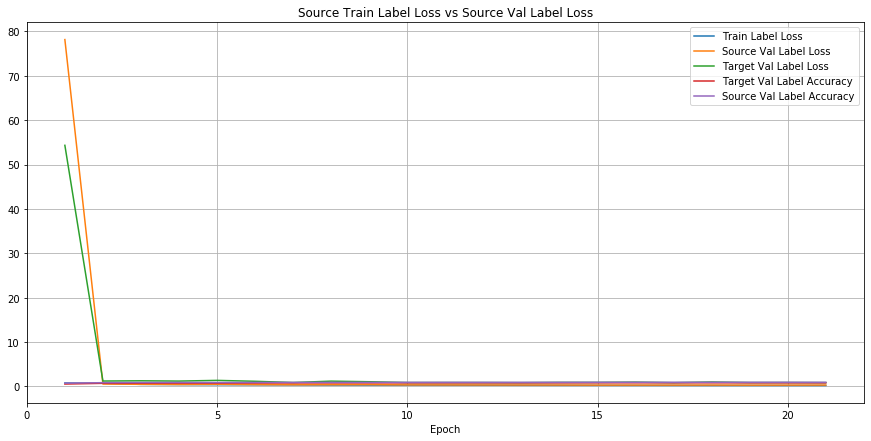

In [16]:
ax = get_loss_curve(experiment)
plt.show()

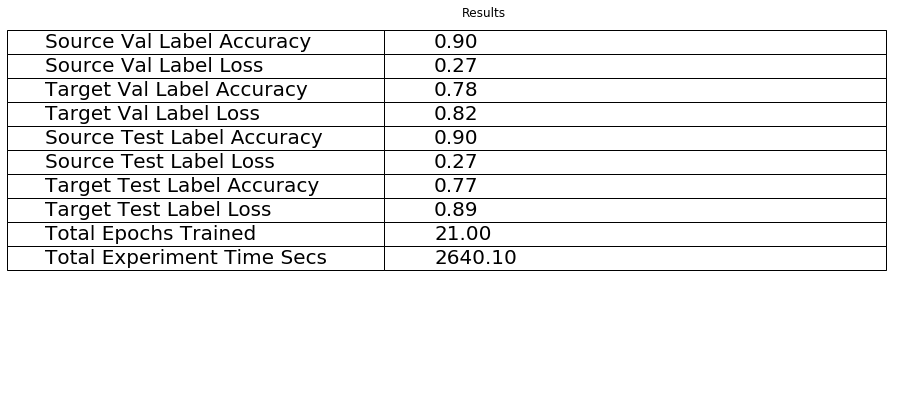

In [17]:
get_results_table(experiment)

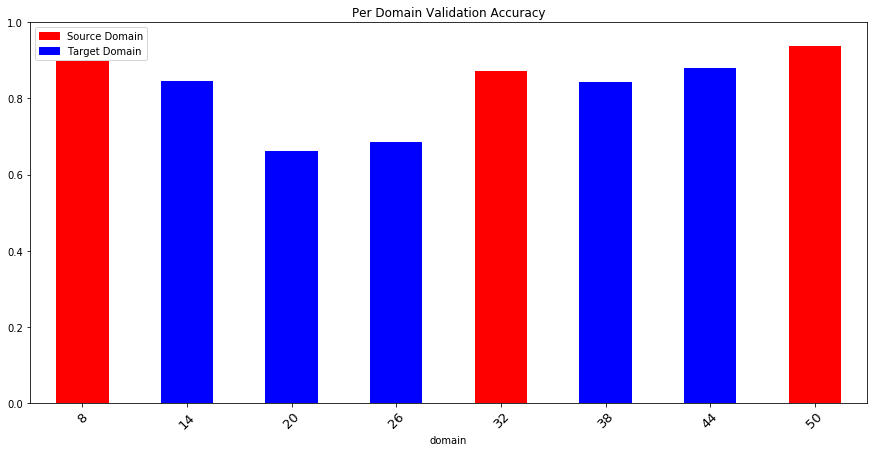

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9038888888888889 Target Test Label Accuracy: 0.7703125
Source Val Label Accuracy: 0.9030555555555555 Target Val Label Accuracy: 0.7832291666666666


In [20]:
json.dumps(experiment)

'{"experiment_name": "nQuery_oracle.run2", "parameters": {"experiment_name": "nQuery_oracle.run2", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "x_transforms_source": [], "x_transforms_target": [], "episode_transforms_source": [], "episode_transforms_target": [], "num_examples_per_domain_per_label_target": 1000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}